In [1]:
import numpy as np
import os
import random
import tensorflow as tf

SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)    


In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
model = Sequential()
model.add(MobileNetV2(include_top = False, weights="imagenet", input_shape=(224, 224, 3)))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].trainable = False
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

train_data_dir = "./dataset/mix/train"
validation_data_dir = "./dataset/validation"



model.compile(optimizer=RMSprop(learning_rate=0.01), loss = 'binary_crossentropy', metrics = 'accuracy')


train_datagen = ImageDataGenerator(rescale = 1./255,)

validation_datagen = ImageDataGenerator(rescale=1./255)

img_rows, img_cols = 224,224

checkpoint = ModelCheckpoint('./model/MobileNet_Mix_Binary.h5',
                            monitor="loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystop = EarlyStopping(monitor = "loss",
                         min_delta=0,
                         patience = 3,
                         verbose = 1,
                         restore_best_weights = True)

callbacks = [earlystop, checkpoint]
batch_size = 13

train_generator= train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='binary')


validation_generator= validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='binary')

Found 576 images belonging to 2 classes.
Found 129 images belonging to 2 classes.


In [5]:
history = model.fit(train_generator,
steps_per_epoch=10,
epochs=100,
validation_data = validation_generator,
callbacks=callbacks,
validation_steps=10)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 1.9593 - accuracy: 0.5308
Epoch 1: loss improved from inf to 1.95931, saving model to ./model\MobileNet_Mix_Binary.h5
10/10 [==============================] - 17s 738ms/step - loss: 1.9593 - accuracy: 0.5308 - val_loss: 0.6480 - val_accuracy: 0.6202
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.6276 - accuracy: 0.7692
Epoch 2: loss improved from 1.95931 to 0.62761, saving model to ./model\MobileNet_Mix_Binary.h5
10/10 [==============================] - 4s 446ms/step - loss: 0.6276 - accuracy: 0.7692 - val_loss: 0.5073 - val_accuracy: 0.7752
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.7154
Epoch 3: loss did not improve from 0.62761
10/10 [==============================] - 2s 252ms/step - loss: 0.6833 - accuracy: 0.7154 - val_loss: 0.6204 - val_accuracy: 0.7287
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.5629 - accuracy: 0.

In [6]:
scores = model.evaluate(validation_generator,verbose=1)
print('test loss:', scores[0])
print('test accuracy:', scores[1])

10/10 [==============================] - 1s 95ms/step - loss: 0.3146 - accuracy: 0.8605
test loss: 0.3145884573459625
test accuracy: 0.8604651093482971


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


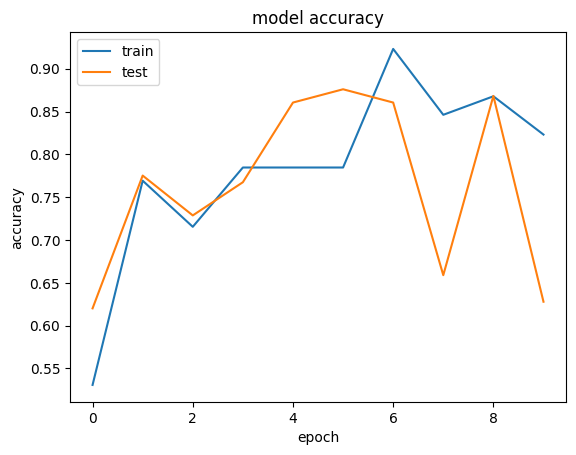

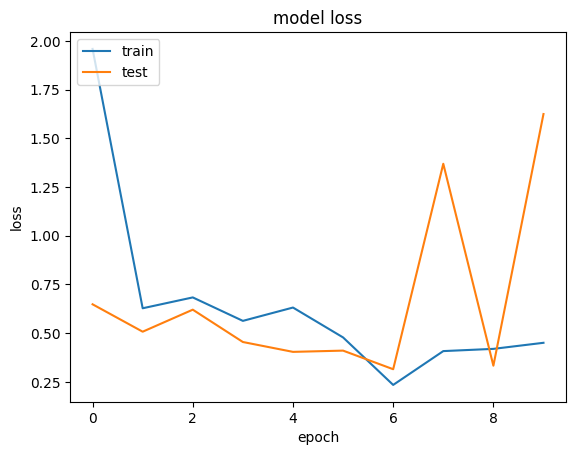

In [7]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
scores = model.evaluate(validation_generator,verbose=1)
print('test loss:', scores[0])
print('test accuracy:', scores[1])

10/10 [==============================] - 1s 110ms/step - loss: 0.3146 - accuracy: 0.8605
test loss: 0.31458839774131775
test accuracy: 0.8604651093482971


In [9]:
from tensorflow.keras.models import load_model
classifier = load_model('./model/MobileNet_Cluster_Binary.h5')

import cv2
from os import listdir
from os.path import isfile, join

road_dic = {"[[0.]]": "Warninng",
             "[[1.]]": "No warning"}
def draw_test(name, pred, im):
    road = road_dic[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im,80,0,0,100,cv2.BORDER_CONSTANT,value=BLACK)
    if road == "Warninng":
        cv2.putText(expanded_image,road,(20,60), cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
    else :
        cv2.putText(expanded_image,road,(20,60), cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)    
    cv2.imshow(name,expanded_image)
    
def getRandomImage(path):
    """function loads a random images from a random folder in out test path"""
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path,x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)


for i in range (0,10):
    input_im = getRandomImage("./dataset/cluster/validation/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original,None, fx=2, fy=2, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im,(224,224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im /255.
    input_im= input_im.reshape(1,224,224,3)
    
    res = np.round(classifier.predict(input_im, 1, verbose = 0))
    draw_test("Prediction",res, input_original)
    print(classifier.predict(input_im, 1, verbose = 0))
    cv2.waitKey(0)
    
cv2.destroyAllWindows()

[[0.8291946]]
[[0.08716032]]
[[0.3825809]]
[[1.9586572e-05]]
[[9.139197e-05]]
[[5.5158563e-07]]
[[0.06649242]]
[[0.01219861]]
[[0.00010943]]
[[0.8291946]]
